In [1]:
import numpy as np
import igraph as ig
from scipy.special import betaln

Data Generation

In [125]:
theta = np.array([[0.75, 0.25, 0.1, 0.9, 0.75],
                  [0.1, 0.75, 0.1, 0.1, 0.25],
                  [0.1, 0.75, 0.25, 0.9, 0.25],
                  [0.75, 0.9, 0.25, 0.25, 0.75]])

In [126]:
Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

In [127]:
Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

In [128]:
theta[z0[0][0], z0[1][1]]

0.75

In [129]:
N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

In [130]:
def generate_graph_bicluster(Sr, Sc, thetas, random_seed = None):
    # Kr = thetas.shape[0]
    # Kc = thetas.shape[1]

    N = np.sum(Sr)

    Hr = []
    c = 0
    for i in Sr:
        for j in range(i):
            Hr += [c]
        c+=1

    Hc = []
    c = 0
    for i in Sc:
        for j in range(i):
            Hc += [c]
        c+=1

    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    X = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            X[i, j] = np.random.binomial(1, thetas[Hr[i], Hc[j]])

    return X


In [131]:
X = generate_graph_bicluster(Sr, Sc, theta, random_seed=1)

In [9]:
def irm_bicluster(X, T, a, b, A, set_seed = True, random_seed = 42, print_iter = False):
    N = len(X)
    zr = np.ones([N, 1])
    zc = np.ones([N, 1])
    Z = []
    Zr = []
    Zc = []

    if set_seed:
        np.random.seed(random_seed)

    for t in range(T):
        for n in range(N):
            nn = [_ for _ in range(N)]
            nn.remove(n)

            X_ = X.copy().astype(int)
            X_[n,:] = 0

            Kr = len(zr[0])

            if Kr > 1:
                idx = np.argwhere(np.sum(zr[nn], 0) == 0)
                zr = np.delete(zr, idx, axis=1)
                Kr -= len(idx)

            # m = n. of nodes in each component 
            mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
            mc = np.sum(zc[nn,:], 0)[np.newaxis]
            Mc = np.tile(mc, (Kr, 1))
            M1 = zr.T @ X_ @ zc

            X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links
            X_rev[n,:] = 0
            M0 = zr.T @ X_rev @ zc #n. of non-links between biclusters without current node

            r = zc[nn,:].T @ X[n, nn]
            R = np.tile(r, (Kr, 1))

            logLik_exComp = np.sum(betaln(M1+R+a, M0+Mc-R+b) - betaln(M1+a, M0+b),1)
            logLik_newComp = np.sum(betaln(r+a, mc-r+b) - betaln(a,b),1)

            logLik = np.concatenate([logLik_exComp, logLik_newComp])
            logPrior = np.log(np.append(mr, A))

            logPost = logPrior + logLik

            P = np.exp(logPost-max(logPost)) 

            # Assignment through random draw fron unif(0,1), taking first value from prob. vector
            draw = np.random.rand()
            i = np.argwhere(draw<np.cumsum(P)/sum(P))[0]

            zr[n,:] = 0
            if i == Kr: # If new component: add new column to partition matrix
                zr = np.hstack((zr, np.zeros((N,1)))) 
            zr[n,i] = 1

        for n in range(N):
            nn = [_ for _ in range(N)]
            nn.remove(n)

            X_ = X.copy().astype(int)
            X_[:,n] = 0

            Kc = len(zc[0])

            if Kc > 1:
                idx = np.argwhere(np.sum(zc[nn], 0) == 0)
                zc = np.delete(zc, idx, axis=1)
                Kc -= len(idx)

            # m = n. of nodes in each component 
            mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
            mc = np.sum(zc[nn,:], 0)[np.newaxis]
            Mr = np.tile(mr.T, (1, Kc))

            M1 = zr.T @ X_ @ zc

            X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links
            X_rev[:,n] = 0
            M0 = zr.T @ X_rev @ zc #n. of non-links between biclusters without current node

            s = zr[nn,:].T @ X[nn, n]
            S = np.tile(s[np.newaxis].T, (1, Kc))

            logLik_exComp = np.sum(betaln(M1+S+a, M0+Mr-S+b) - betaln(M1+a, M0+b), 0)
            logLik_newComp = np.sum(betaln(s+a, mr-s+b) - betaln(a,b),1)

            logLik = np.concatenate([logLik_exComp, logLik_newComp])
            logPrior = np.log(np.append(mc, A))

            logPost = logPrior + logLik

            P = np.exp(logPost-max(logPost)) 

            # Assignment through random draw fron unif(0,1), taking first value from prob. vector
            draw = np.random.rand()
            i = np.argwhere(draw<np.cumsum(P)/sum(P))[0]

            zc[n,:] = 0
            if i == Kc: # If new component: add new column to partition matrix
                zc = np.hstack((zc, np.zeros((N,1)))) 
            zc[n,i] = 1

        Z.append([zr.copy(), zc.copy()])
        Zr.append(zr.copy())
        Zc.append(zc.copy())
    
    return [Zr, Zc]

In [10]:
X

array([[0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.]])

In [132]:
T = 5000
a = 1
b = 1
A = 1

In [133]:
Z = irm_bicluster(X, T , a, b, A, set_seed = True, random_seed = 42)

In [134]:
Z_bi = Z.copy()

In [135]:
Z = Z_bi.copy()

In [136]:
from igraph.clustering import compare_communities
from scipy.special import betaln
from eval import retrieve_samples, compute_Zhat

In [137]:
def compute_VIs(C):
    N = len(C)
    VIs = np.zeros((N,N))

    for i in range(N):
        for j in range(i):
            VIs[i,j] = compare_communities(C[i], C[j])

    VIs += VIs.T

    return VIs

def compute_edge_quantities(X, zr, zc = None, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1 = zr.T @ X @ zr
        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zr


    if mode == 'biclustering':
        M1 = zr.T @ X @ zc

        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zc

    return M1, M0

def compute_logL(X, zr, zc = None, a=1, b=1, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1, M0 = compute_edge_quantities(X, zr, mode = 'uniclustering')
        

    if mode == 'biclustering':
        M1, M0 = compute_edge_quantities(X, zr, zc, mode = 'biclustering')
    
    logLlhood = np.sum(betaln(M1 + a, M0 + b) - betaln(a, b))
    return logLlhood

def compute_logLs(X, Z, mode = 'biclustering'):
    if mode == 'uniclustering':
        N = len(Z)
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[i], mode = 'uniclustering')
    if mode == 'biclustering':
        N = len(Z[0])
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[0][i], Z[1][i], mode = 'biclustering')

    return logLs

def compute_Zhat(X, Z, mode = 'biclustering', weight_llhood = False, ret_VI = False, ret_all = False):
    if mode == 'uniclustering':
        Z = retrieve_samples(Z, gap = 10)

        C = [np.where(x == 1)[1].tolist() for x in Z]

        VI = compute_VIs(C)
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, Z, mode = 'uniclustering')
            VI *= -logLs        

        idx_min = np.argmin(VI) 
        z_hat = Z[idx_min]
        c_hat = np.where(z_hat==1)[1]

    if mode == 'biclustering':
        Zr = retrieve_samples(Z[0], gap = 10)
        Zc = retrieve_samples(Z[1], gap = 10)

        Cr = [np.where(x == 1)[1].tolist() for x in Zr]
        Cc = [np.where(x == 1)[1].tolist() for x in Zc]

        VIr = compute_VIs(Cr)
        VIc = compute_VIs(Cc)

        VI = (VIr + VIc)/2
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, [Zr, Zc], mode = 'biclustering')
            VI *= -logLs

        idx_min = np.argmin(VI) 
        z_hat = [Zr[idx_min], Zc[idx_min]]
        c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

    if ret_all:
        return [Zr, Zc], VI, idx_min

    if ret_VI:
        return z_hat, VI[idx_min]

    return z_hat

In [138]:
Zr = retrieve_samples(Z[0], gap = 10)
Zc = retrieve_samples(Z[1], gap = 10)

Cr = [np.where(x == 1)[1].tolist() for x in Zr]
Cc = [np.where(x == 1)[1].tolist() for x in Zc]

VIr = 0
VIc = 0
for i in range(len(Cr)):
    VIr += compare_communities(Cr[i], z0[0])
    VIc += compare_communities(Cc[i], z0[1])

VIr = VIr/len(Cr)
VIc = VIc/len(Cc)

VI_relative_true = np.mean([VIr, VIc])

In [139]:
Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

sorted_VI = VI[np.argsort(VI)]
sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

b_threshold = int(len(VI)*0.95)

zr_ball = sorted_Zr[b_threshold]
zc_ball = sorted_Zc[b_threshold]

c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                            compare_communities(c_hat[1], c_ball[1])])

VIr_true = compare_communities(c_hat[0], z0[0])
VIc_true = compare_communities(c_hat[1], z0[1])



In [140]:
print(VIr_true)
print(VIc_true)
print(VI_relative_true)
print(VI_relative_ball)

0.0
0.0
0.11985958709537273
0.20586542500658034


In [141]:
VI_relative_true

0.11985958709537273

In [142]:
VI_relative_ball

0.20586542500658034

In [143]:
Kr_vector = [i.shape[1] for i in sorted_Zr]
Kc_vector = [i.shape[1] for i in sorted_Zc]

In [144]:
print(np.quantile(np.sort(Kr_vector), 0.25))
print(np.quantile(np.sort(Kr_vector), 0.5))
print(np.quantile(np.sort(Kr_vector), 0.75))

4.0
4.0
4.0


In [145]:
print(np.quantile(np.sort(Kc_vector), 0.25))
print(np.quantile(np.sort(Kc_vector), 0.5))
print(np.quantile(np.sort(Kc_vector), 0.75))

5.0
6.0
6.0


In [26]:
def compute_rhos(X, Z, a=1, b=1, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':    
        A = np.array([np.where(Z[i,:] == 1)[0] for i in range(len(Z))]).flatten()

        if edge_type == 'undirected':
            M1 = Z.T @ X @ Z - np.diag(np.sum(X@Z*Z, 0) / 2) 

            m = np.sum(Z, 0)[np.newaxis]

            M0 = m.T@m - np.diag((m*(m+1) / 2).flatten()) - M1 

        elif edge_type == 'directed':
            M1 = Z.T @ X @ Z

            m = np.sum(Z, 0)[np.newaxis]
            M0 = m.T@m - np.diag(m.flatten()) - M1

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[A[i], A[j]]
                non_links = M0[A[i], A[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)

    elif mode == 'biclustering':
        zr = Z[0]
        zc = Z[1]
        cr = np.where(zr==1)[1]
        cc = np.where(zc==1)[1]

        M1 = zr.T @ X @ zc

        X_ = X.copy().astype(int)
        X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links

        M0 = zr.T @ X_rev @ zc

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[cr[i], cc[j]]
                non_links = M0[cr[i], cc[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)
    return rhos

In [27]:
def compute_rho(X, sample, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':
        for i in sample:
            rhos += compute_rhos(X, i, edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample)
    if mode == 'biclustering':
        for i in range(len(sample[0])):
            rhos += compute_rhos(X, [sample[0][i], sample[1][i]], 
                            edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample[0])
    return rhos

def compute_predicted_thetas(Sr, Sc, rho):
    prob_matrix = np.zeros((len(Sr), len(Sc)))

    Sr_ = [0] + list(np.cumsum(Sr))
    Sc_ = [0] + list(np.cumsum(Sc))
    for i in range(len(Sr)):
        for j in range(len(Sc)):
            interaction_matrix = rho[Sr_[i]:Sr_[i+1], Sc_[j]:Sc_[j+1]]
            # if i == j:
            #     if len(interaction_matrix) == 1:
            #         continue
            #     prob_matrix[i,j] += np.sum(interaction_matrix)/(len(interaction_matrix)**2 - len(interaction_matrix))
            # else:
            # prob_matrix[i,j] += np.mean(interaction_matrix)
            prob_matrix[i,j] += np.average(interaction_matrix, weights=(interaction_matrix>0))

    return prob_matrix

In [146]:
rho = compute_rho(X, Zsample, mode = 'biclustering')
predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

In [147]:
np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))

0.016119981905375263

In [148]:
theta

array([[0.75, 0.25, 0.1 , 0.9 , 0.75],
       [0.1 , 0.75, 0.1 , 0.1 , 0.25],
       [0.1 , 0.75, 0.25, 0.9 , 0.25],
       [0.75, 0.9 , 0.25, 0.25, 0.75]])

In [149]:
predicted_thetas

array([[0.70780635, 0.2455688 , 0.11019998, 0.90231522, 0.76243423],
       [0.09375946, 0.72274878, 0.08807514, 0.12154225, 0.2151653 ],
       [0.08988938, 0.75683934, 0.25651242, 0.88899505, 0.20721383],
       [0.73801985, 0.91222783, 0.25539339, 0.25960964, 0.76228764]])

In [32]:
np.mean(np.abs(theta-predicted_thetas))

0.01576032840787413

In [49]:
from collections import Counter

In [88]:
Counter(c_hat[1])

Counter({2: 24, 4: 20, 0: 20, 1: 20, 3: 16})

In [157]:
# prob_matrix = np.zeros((len(Sr), len(Sc)))

# Sr_ = [0] + list(np.cumsum(Sr))
# Sc_ = [0] + list(np.cumsum(Sc))

In [158]:
# for i in range(len(Sr)):
#     for j in range(len(Sc)):
#         interaction_matrix = rho[Sr_[i]:Sr_[i+1], Sc_[j]:Sc_[j+1]]
#         # if i == j:
#         #     if len(interaction_matrix) == 1:
#         #         continue
#         #     prob_matrix[i,j] += np.sum(interaction_matrix)/(len(interaction_matrix)**2 - len(interaction_matrix))
#         # else:
#         prob_matrix[i,j] += np.mean(interaction_matrix)

## IRM Uni-Cluster

In [150]:
from irm import irm

In [151]:
Z = irm(X, 5000 , a, b, 3, set_seed = True, random_seed = 42)
Z_uni = Z.copy()

In [152]:
Z = [Z_uni, Z_uni]

In [153]:
Zr = retrieve_samples(Z[0], gap = 10)
Zc = retrieve_samples(Z[1], gap = 10)

Cr = [np.where(x == 1)[1].tolist() for x in Zr]
Cc = [np.where(x == 1)[1].tolist() for x in Zc]

VIr = 0
VIc = 0
for i in range(len(Cr)):
    VIr += compare_communities(Cr[i], z0[0])
    VIc += compare_communities(Cc[i], z0[1])

VIr = VIr/len(Cr)
VIc = VIc/len(Cc)

VI_relative_true = np.mean([VIr, VIc])

In [154]:
Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

sorted_VI = VI[np.argsort(VI)]
sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

b_threshold = int(len(VI)*0.95)

zr_ball = sorted_Zr[b_threshold]
zc_ball = sorted_Zc[b_threshold]

c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                            compare_communities(c_hat[1], c_ball[1])])

VIr_true = compare_communities(c_hat[0], z0[0])
VIc_true = compare_communities(c_hat[1], z0[1])


In [155]:
print(VIr_true)
print(VIc_true)
print(VI_relative_true)
print(VI_relative_ball)

0.5867070452737218
0.36356349395951204
0.4752822276326954
0.0


In [156]:
Kr_vector = [i.shape[1] for i in sorted_Zr]
Kc_vector = [i.shape[1] for i in sorted_Zc]

In [157]:
print(np.quantile(np.sort(Kr_vector), 0.25))
print(np.quantile(np.sort(Kr_vector), 0.5))
print(np.quantile(np.sort(Kr_vector), 0.75))

8.0
8.0
8.0


In [158]:
Zsample

[[array([[1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.],
         [0

In [159]:
rho = compute_rho(X, Zsample, mode = 'biclustering')
predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

In [160]:
np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))

0.02790383735492044

In [161]:
theta

array([[0.75, 0.25, 0.1 , 0.9 , 0.75],
       [0.1 , 0.75, 0.1 , 0.1 , 0.25],
       [0.1 , 0.75, 0.25, 0.9 , 0.25],
       [0.75, 0.9 , 0.25, 0.25, 0.75]])

In [162]:
predicted_thetas

array([[0.70027675, 0.24878079, 0.11439452, 0.89760579, 0.76772022],
       [0.07936458, 0.71989783, 0.09236523, 0.12613911, 0.23214581],
       [0.07931939, 0.75405925, 0.25905179, 0.88434881, 0.22021507],
       [0.73391864, 0.90739409, 0.25792079, 0.26254523, 0.76461178]])

## Uni-partite Model

In [8]:
theta = np.array([[0.75, 0.25, 0.25, 0.25, 0.25],
                  [0.25, 0.75, 0.25, 0.25, 0.25],
                  [0.25, 0.25, 0.75, 0.25, 0.25],
                  [0.25, 0.25, 0.25, 0.75, 0.25],
                  [0.25, 0.25, 0.25, 0.25, 0.75]])

Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

In [9]:
N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

In [49]:
X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40)

In [163]:
T = 5000
a = 1
b = 1
A = 3

Z = irm_bicluster(X, T , a, b, A, set_seed = True, random_seed = 42)
Z_bi = Z.copy()

In [164]:
Z = Z_bi.copy()

In [205]:
Z = [Z_bi[0][len(Z_bi[0])//2:].copy(), Z_bi[1][len(Z_bi[1])//2:].copy()]

In [192]:
len(Z[0])

2500

In [206]:
Zr = retrieve_samples(Z[0], gap = 10)
Zc = retrieve_samples(Z[1], gap = 10)

Cr = [np.where(x == 1)[1].tolist() for x in Zr]
Cc = [np.where(x == 1)[1].tolist() for x in Zc]

VIr = 0
VIc = 0
for i in range(len(Cr)):
    VIr += compare_communities(Cr[i], z0[0])
    VIc += compare_communities(Cc[i], z0[1])

VIr = VIr/len(Cr)
VIc = VIc/len(Cc)

VI_relative_true = np.mean([VIr, VIc])

Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

sorted_VI = VI[np.argsort(VI)]
sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

b_threshold = int(len(VI)*0.95)

zr_ball = sorted_Zr[b_threshold]
zc_ball = sorted_Zc[b_threshold]

c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                            compare_communities(c_hat[1], c_ball[1])])

VIr_true = compare_communities(c_hat[0], z0[0])
VIc_true = compare_communities(c_hat[1], z0[1])

In [207]:
print(VIr_true)
print(VIc_true)
print(VI_relative_true)
print(VI_relative_ball)

0.0
0.0
0.058787302558554605
0.12167453972972675


In [208]:
Kr_vector = [i.shape[1] for i in sorted_Zr]
Kc_vector = [i.shape[1] for i in sorted_Zc]

In [209]:
print(np.quantile(np.sort(Kr_vector), 0.25))
print(np.quantile(np.sort(Kr_vector), 0.5))
print(np.quantile(np.sort(Kr_vector), 0.75))

6.0
6.0
7.0


In [210]:
print(np.quantile(np.sort(Kc_vector), 0.25))
print(np.quantile(np.sort(Kc_vector), 0.5))
print(np.quantile(np.sort(Kc_vector), 0.75))

5.0
5.0
6.0


In [211]:
Counter(Kr_vector)

Counter({5: 21, 6: 58, 7: 32, 8: 11, 9: 3})

In [171]:
Zc

[array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0

In [172]:
c_hat

[array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)]

In [22]:
from collections import Counter

In [173]:
Counter(c_hat[0])

Counter({3: 20, 0: 20, 4: 20, 1: 20, 2: 20})

In [212]:
rho = compute_rho(X, Zsample, mode = 'biclustering')
predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

In [213]:
np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))

0.016483308857819474

In [161]:
theta

array([[0.75, 0.25, 0.25, 0.25, 0.25],
       [0.25, 0.75, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.75, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.75, 0.25],
       [0.25, 0.25, 0.25, 0.25, 0.75]])

In [162]:
predicted_thetas

array([[0.73266597, 0.30030726, 0.23011408, 0.2551779 , 0.27125075],
       [0.26455415, 0.7393561 , 0.21932723, 0.2542834 , 0.28171865],
       [0.22951507, 0.25705328, 0.74497489, 0.24234668, 0.22246449],
       [0.26526394, 0.26013027, 0.23700566, 0.78027384, 0.25705145],
       [0.24526341, 0.25655633, 0.2541095 , 0.27168021, 0.73560424]])

### Using Uni-partition

In [145]:
Z = irm(X, 5000, a, b, 5, set_seed = True, random_seed = 42)
Z_uni = Z.copy()

In [195]:
Z = [Z_uni, Z_uni]

In [214]:
Z = [Z_uni[len(Z_uni)//2:], Z_uni[len(Z_uni)//2:]]

In [199]:
len(Z[0])

2500

In [215]:
Zr = retrieve_samples(Z[0], gap = 10)
Zc = retrieve_samples(Z[1], gap = 10)

Cr = [np.where(x == 1)[1].tolist() for x in Zr]
Cc = [np.where(x == 1)[1].tolist() for x in Zc]

VIr = 0
VIc = 0
for i in range(len(Cr)):
    VIr += compare_communities(Cr[i], z0[0])
    VIc += compare_communities(Cc[i], z0[1])

VIr = VIr/len(Cr)
VIc = VIc/len(Cc)

VI_relative_true = np.mean([VIr, VIc])

Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

sorted_VI = VI[np.argsort(VI)]
sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

b_threshold = int(len(VI)*0.95)

zr_ball = sorted_Zr[b_threshold]
zc_ball = sorted_Zc[b_threshold]

c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                            compare_communities(c_hat[1], c_ball[1])])

VIr_true = compare_communities(c_hat[0], z0[0])
VIc_true = compare_communities(c_hat[1], z0[1])

In [216]:
print(VIr_true)
print(VIc_true)
print(VI_relative_true)
print(VI_relative_ball)

0.0
0.0
0.002223370725473785
0.039703048669174734


In [217]:
Kr_vector = [i.shape[1] for i in sorted_Zr]
Kc_vector = [i.shape[1] for i in sorted_Zc]

In [218]:
print(np.quantile(np.sort(Kr_vector), 0.25))
print(np.quantile(np.sort(Kr_vector), 0.5))
print(np.quantile(np.sort(Kr_vector), 0.75))

5.0
5.0
5.0


In [219]:
c_hat

[array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)]

In [220]:
rho = compute_rho(X, Zsample, mode = 'biclustering')
predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

In [221]:
np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))

0.015528236671479628

In [123]:
theta

array([[0.75, 0.25, 0.25, 0.25, 0.25],
       [0.25, 0.75, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.75, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.75, 0.25],
       [0.25, 0.25, 0.25, 0.25, 0.75]])

In [126]:
predicted_thetas

array([[0.64600934, 0.29058636, 0.2311437 , 0.31645033, 0.29584314],
       [0.26330204, 0.7408377 , 0.21891176, 0.25651306, 0.27813635],
       [0.22974297, 0.25622002, 0.74606331, 0.23827088, 0.2228995 ],
       [0.32329046, 0.26340349, 0.23626181, 0.67813671, 0.28732781],
       [0.27818484, 0.25891939, 0.2508898 , 0.29691977, 0.67800057]])

In [128]:
Counter(c_hat[1])

Counter({4: 20, 1: 20, 2: 20, 0: 20, 3: 20})

In [92]:
c_hat[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [93]:
c_hat[1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [99]:
K_vec = [i.shape[1] for i in Zsample[0]]

In [104]:
K_vec

[5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 5,
 6,
 6,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 6,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 6,
 4,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 5,


In [187]:
from collections import Counter

In [98]:
Kr_vector

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [97]:
Counter(Kr_vector)

Counter({4: 192, 5: 276, 6: 32})

In [59]:
np.sort(Kc_vector)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 6])

In [89]:
import seaborn as sns
import matplotlib.pylab as plt

In [78]:
def pr_cc(Z, mode = 'biclustering'):
    if mode == 'biclustering':
        Zr = Z[0]
        Zc = Z[1]
        N = Zr[0].shape[0]
        C = np.zeros((N,N))
        for i in range(len(Zr)):
            C += (Zr[i]@Zc[i].T) * (Zc[i]@Zr[i].T)

        return C/len(Zr)

    if mode == 'uniclustering':
        N = Z[0].shape[0]
        C = np.zeros((N,N))
        for i in range(len(Z)):
            C += (Z[i]@Z[i].T)

        return C/len(Z)



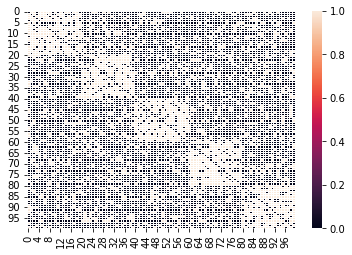

In [111]:
ax = sns.heatmap(X, linewidth=0.5)
plt.show()

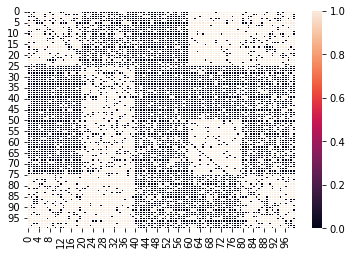

In [97]:
ax = sns.heatmap(X, linewidth=0.5)
plt.show()

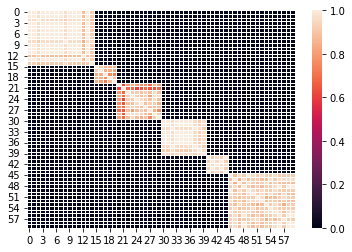

In [76]:
ax = sns.heatmap(pr_cc([Zr, Zc]), linewidth=0.5)
plt.show()

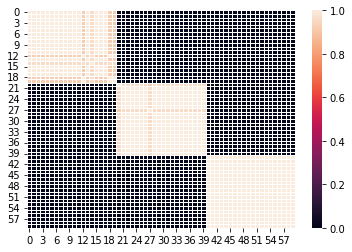

In [74]:
ax = sns.heatmap(pr_cc(Zr, mode ='uniclustering'), linewidth=0.5)
plt.show()

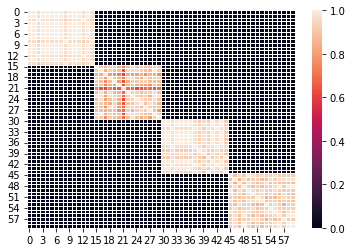

In [75]:
ax = sns.heatmap(pr_cc(Zc, mode ='uniclustering'), linewidth=0.5)
plt.show()

In [83]:
Zr = retrieve_samples(Z[0], gap = 10)
Zc = retrieve_samples(Z[1], gap = 10)

Cr = [np.where(x == 1)[1].tolist() for x in Zr]
Cc = [np.where(y == 1)[1].tolist() for y in Zc]

logLs = compute_logLs(X, [Zr, Zc], mode = 'biclustering')

VIr = compute_VIs(Cr)
VIc = compute_VIs(Cc)

VI = (VIr + VIc)/2
VI = VI.sum(0)/VI.shape[0]
VI *= logLs

idx_min = np.argmin(VI) 
z_hat = [Zr[idx_min], Zc[idx_min]]
c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

In [84]:
c_hat

[array([0, 1, 1, 2, 0], dtype=int64), array([1, 1, 0, 0, 0], dtype=int64)]

In [79]:
z_hat = [Zr[idx_min], Zc[idx_min]]

In [81]:
z_hat

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]]),
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])]

In [82]:
np.where(z_hat[0]==1)[1]

array([0, 1, 1, 2, 0], dtype=int64)

In [65]:
logLs

[-12.712215321391783,
 -12.619505923287514,
 -12.021668922531894,
 -14.252660362338933,
 -11.585432155756976,
 -12.550513051800563,
 -12.460900893110876,
 -11.749735207048253,
 -12.021668922531894,
 -13.628506053265937,
 -14.727118341934046,
 -15.79755975363546,
 -14.727118341934046,
 -15.35572700135642,
 -12.396362371973304,
 -12.907187995739296,
 -13.089509552533249,
 -15.173816882543996,
 -14.970881180450993,
 -14.950261893248255,
 -12.801827480081469,
 -11.143599403477936,
 -12.668296087456948,
 -13.851649604580146,
 -12.396362371973305]

In [61]:
def compute_VIs(C):
    N = len(C)
    VIs = np.zeros((N,N))

    for i in range(N):
        for j in range(i):
            VIs[i,j] = compare_communities(C[i], C[j])

    VIs += VIs.T

    return VIs

def compute_edge_quantities(X, zr, zc = None, mode = 'biclustering'):
    if mode == 'biclustering':
        mr = np.sum(zr, 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
        mc = np.sum(zc, 0)[np.newaxis]

        M1 = zr.T @ X @ zc

        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zc

    return M1, M0

# def compute_logL(X, zr, zc, a=1, b=1):
#     M1, M0 = compute_edge_quantities(X, zr, zc)

def compute_logL_bicl(X, zr, zc, a=1, b=1):
    M1, M0 = compute_edge_quantities(X, zr, zc, mode = 'biclustering')
    logLlhood = np.sum(betaln(M1 + a, M0 + b) - betaln(a, b))
    return logLlhood



def compute_logLs(X, Z, mode = 'biclustering'):
    
    if mode == 'biclustering':
        N = len(Z[0])
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL_bicl(X, Z[0][i], Z[1][i])

    return logLs


In [62]:
VI

array([[ -0.        , -10.06780156,  -8.33278592, -10.62495915,
         -5.81812212,  -6.30277892,  -8.86583364,  -6.51543666,
         -8.33278592,  -6.38104538, -11.74924802, -13.42984715,
         -7.6660238 , -12.25075001, -12.25691643, -12.76199581,
         -9.7578628 , -15.62376629, -13.23577748, -13.99981761,
         -9.63202   ,  -5.21757947,  -9.53155176,  -9.13055548,
         -8.17127762],
       [-10.14176482,  -0.        ,  -6.66622874, -16.55247396,
         -7.42420405, -11.52239057, -10.5932813 ,  -8.14429583,
         -6.66622874, -15.82760592,  -9.70763591, -15.61985395,
        -13.79086013, -22.89452888, -10.53841571, -14.551312  ,
         -7.94327147, -15.10816291, -15.31118229, -11.92727124,
         -7.85730988,  -6.76241038,  -7.77535302, -14.89129461,
         -1.71850073],
       [ -8.81143621,  -6.99773996,  -0.        , -11.10926181,
         -5.42445137,  -5.87631491,  -4.53032867,  -1.62885917,
         -0.        , -12.0489817 , -13.79086013, -15.6198

In [162]:
# for t in range(T):
#     for n in range(N):
a = 1
b = 1
A = 1

N = len(X)
for i in range(N):
    nn = [_ for _ in range(N)]
    nn.remove(n)

    # X_ = X[np.ix_(nn,nn)]

    X_ = X.copy()
    X_[n,:] = 0

    Kr = len(zr[0])
    Kc = len(zc[0])

    if Kr > 1:
        idx = np.argwhere(np.sum(zr[nn], 0) == 0)
        zr = np.delete(zr, idx, axis=1)
        Kr -= len(idx)

    # m = n. of nodes in each component 
    mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
    mc = np.sum(zc[nn,:], 0)[np.newaxis]
    Mc = np.tile(mc, (Kr, 1))

    # M = max links from other clusts
    # M = np.tile(m, (Kr, 1))

    M1 = zr.T @ X_ @ zc

    X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links
    X_rev[n,:] = 0
    M0 = zr.T @ X_rev @ zc #n. of non-links between biclusters without current node

    r = zc[nn,:].T @ X[n, nn]
    R = np.tile(r, (Kr, 1))

    logLik_exComp = np.sum(betaln(M1+R+a, M0+Mc-R+b) - betaln(M1+a, M0+b),1)
    logLik_newComp = np.sum(betaln(r+a, mc-r+b) - betaln(a,b),1)

    logLik = np.concatenate([logLik_exComp, logLik_newcomp])
    logPrior = np.log(np.append(mr, A))

    logPost = logPrior + logLik

    P = np.exp(logPost-max(logPost)) 

    # Assignment through random draw fron unif(0,1), taking first value from prob. vector
    draw = np.random.rand()
    i = np.argwhere(draw<np.cumsum(P)/sum(P))[0]

    zr[n,:] = 0
    if i == Kr: # If new component: add new column to partition matrix
        zr = np.hstack((zr, np.zeros((N,1)))) 
    zr[n,i] = 1


In [16]:
N = len(X)

zr = np.ones([N, 1])
zc = np.ones([N, 1])

In [17]:
n = 0

nn = [_ for _ in range(N)]
nn.remove(n)

# X_ = X[np.ix_(nn,nn)]

X_ = X.copy()
X_[:,n] = 0

Kr = len(zr[0])
Kc = len(zc[0])

In [20]:
mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
mc = np.sum(zc[nn,:], 0)[np.newaxis]
Mc = np.tile(mc, (Kr, 1))

M1 = zr.T @ X_ @ zc

In [32]:
X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy()

In [31]:
X_ = X_.astype(int)

In [33]:
n = 0

nn = [_ for _ in range(N)]
nn.remove(n)

# X_ = X[np.ix_(nn,nn)]

X_ = X.copy().astype(int)
X_[:,n] = 0

Kr = len(zr[0])
Kc = len(zc[0])

if Kr > 1:
    idx = np.argwhere(np.sum(zr[nn], 0) == 0)
    zr = np.delete(zr, idx, axis=1)
    Kr -= len(idx)

# m = n. of nodes in each component 
mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
mc = np.sum(zc[nn,:], 0)[np.newaxis]
Mc = np.tile(mc, (Kr, 1))

# M = max links from other clusts
# M = np.tile(m, (Kr, 1))

M1 = zr.T @ X_ @ zc

X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links
X_rev[n,:] = 0
M0 = zr.T @ X_rev @ zc #n. of non-links between biclusters without current node

r = zc[nn,:].T @ X[n, nn]
R = np.tile(r, (Kr, 1))

logLik_exComp = np.sum(betaln(M1+R+a, M0+Mc-R+b) - betaln(M1+a, M0+b),1)
logLik_newComp = np.sum(betaln(r+a, mc-r+b) - betaln(a,b),1)

logLik = np.concatenate([logLik_exComp, logLik_newComp])
logPrior = np.log(np.append(mr, A))

logPost = logPrior + logLik

P = np.exp(logPost-max(logPost)) 

# Assignment through random draw fron unif(0,1), taking first value from prob. vector
draw = np.random.rand()
i = np.argwhere(draw<np.cumsum(P)/sum(P))[0]

zr[n,:] = 0
if i == Kr: # If new component: add new column to partition matrix
    zr = np.hstack((zr, np.zeros((N,1)))) 
zr[n,i] = 1

NameError: name 'logLik_newcomp' is not defined

In [297]:
for n in range(N):
    nn = [_ for _ in range(N)]
    nn.remove(n)

    # X_ = X[np.ix_(nn,nn)]

    X_ = X.copy()
    X_[:,n] = 0

    Kr = len(zr[0])
    Kc = len(zc[0])

    if Kc > 1:
        idx = np.argwhere(np.sum(zc[nn], 0) == 0)
        zc = np.delete(zc, idx, axis=1)
        Kc -= len(idx)

    # m = n. of nodes in each component 
    mr = np.sum(zr[nn,:], 0)[np.newaxis] #newaxis allows m to become 2d array (for transposing)
    mc = np.sum(zc[nn,:], 0)[np.newaxis]
    Mr = np.tile(mr.T, (1, Kc))

    M1 = zr.T @ X_ @ zc

    X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links
    X_rev[:,0] = 0
    M0 = zr.T @ X_rev @ zc #n. of non-links between biclusters without current node

    s = zr[nn,:].T @ X[nn, n]
    S = np.tile(s[np.newaxis].T, (1, Kc))

    logLik_exComp = np.sum(betaln(M1+S+a, M0+Mr-S+b) - betaln(M1+a, M0+b), 0)
    logLik_newComp = np.sum(betaln(s+a, mr-s+b) - betaln(a,b),1)

    logLik = np.concatenate([logLik_exComp, logLik_newComp])
    logPrior = np.log(np.append(mc, A))

    logPost = logPrior + logLik

    P = np.exp(logPost-max(logPost)) 

    # Assignment through random draw fron unif(0,1), taking first value from prob. vector
    draw = np.random.rand()
    i = np.argwhere(draw<np.cumsum(P)/sum(P))[0]

    zc[n,:] = 0
    if i == Kc: # If new component: add new column to partition matrix
        zc = np.hstack((zc, np.zeros((N,1)))) 
    zc[n,i] = 1

In [298]:
zc

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [268]:
np.sum(betaln(M1+S+a, M0+Mr-S+b) - betaln(M1+a, M0+b), 0)

array([-4.19970508, -3.14988295, -3.40119738])

In [271]:
np.sum(betaln(s+a, mr-s+b) - betaln(a,b), 1)

array([-2.89037176])

In [289]:
zc[n,:] = 0
if i == Kc: # If new component: add new column to partition matrix
    zc = np.hstack((zc, np.zeros((N,1)))) 
zc[n,i] = 1

In [290]:
zc

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [85]:
#test X
X = np.array([[0, 1, 0, 0, 1],
              [0, 0, 1, 1, 0],
              [0, 1, 0, 1, 1],
              [1, 1, 0, 0, 1],
              [0, 1, 0, 1, 0]])

zr = np.array([[1, 0],
               [1, 0],
               [1, 0],
               [0, 1],
               [0, 1]])

# zc = np.array([[1, 0, 0],
#                [1, 0, 0],
#                [0, 1, 0],
#                [0, 1, 0],
#                [0, 0, 1]])

a = 1
b = 1
A = 1

In [86]:
M1 = zr.T @ X @ zr

In [87]:
M1

array([[3, 4],
       [3, 2]])

In [88]:
X = X.copy().astype(int)
X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
M0 = zr.T @ X_rev @ zr

In [89]:
M0

array([[3., 2.],
       [3., 0.]])